In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-used-cars-dataset/used_cars_data.csv


In [2]:
df = pd.read_csv("/kaggle/input/us-used-cars-dataset/used_cars_data.csv").drop_duplicates()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# nan_amount = df.isna().sum()
# nan_amount[nan_amount>=df.shape[0]//2]

**vehicle_damage_category, combine_fuel_economy, is_certified** - состоят только из nan

больше 90% nan - **bed, cabin, is_cpo, is_oemcpo**

больше 75% nan - **bed_height, bed_length**

Их исключаем из рассмотрения

**vin** - идентификатор, его тоже исключаем, listing_id - уникальное поле

**price** - таргет

In [4]:
df = df.drop(columns = ["vehicle_damage_category", "combine_fuel_economy", "is_certified", "bed", "cabin", "is_cpo", "is_oemcpo", "bed_height", "bed_length", "vin", "listing_id",
                       "main_picture_url", "engine_cylinders", "wheel_system_display"])

In [5]:
nuniq = df.nunique()

In [6]:
litle_categories = nuniq[nuniq<10].index

In [7]:
import matplotlib.pyplot as plt

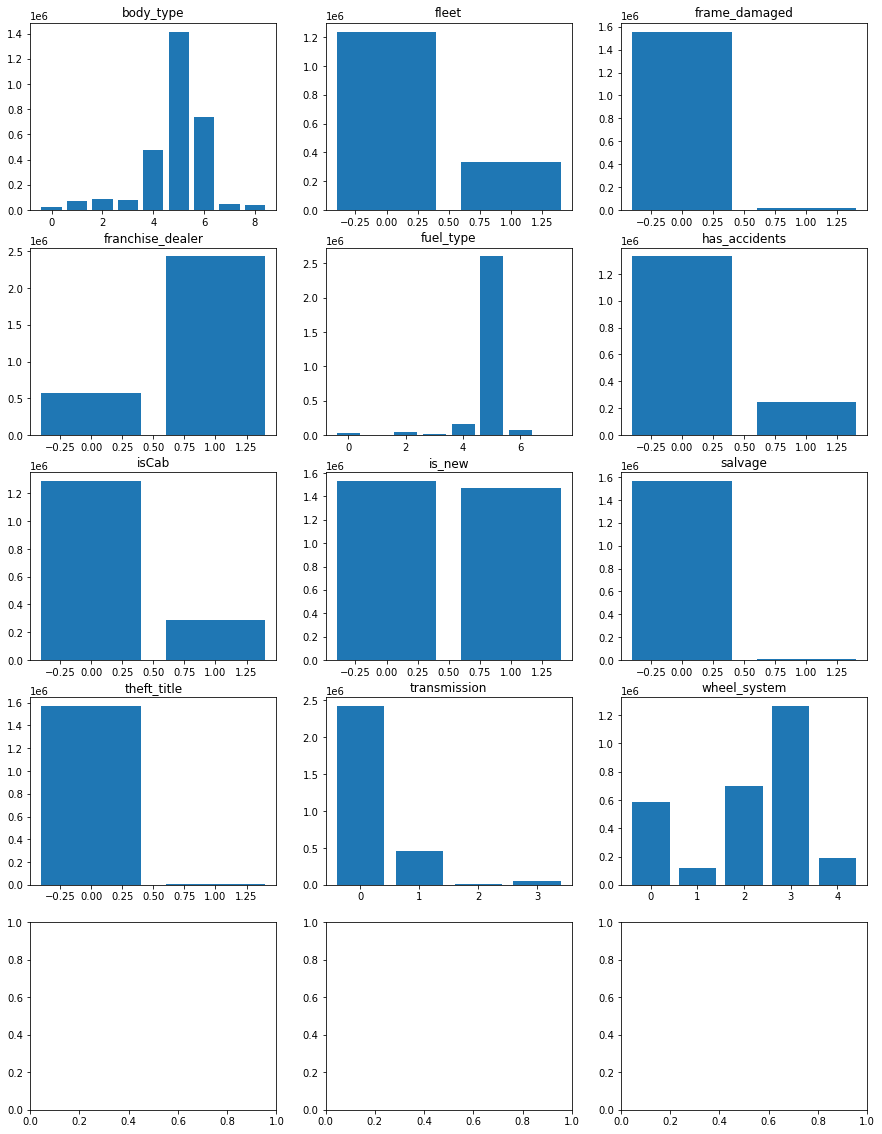

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,20))
for num, cat in enumerate(litle_categories):
    ax = axes.flatten()[num]
    x, height = np.unique(df[cat].dropna(), return_counts=True)
    ax.bar(range(len(x)), height)
    ax.set_title(cat)

Дисбаланс: по всем переменным кроме is_new

Обработка текста

In [9]:
#df["back_legroom"].unique() # содержат значения float и постфикс in, исключения: nan, "--",0 in (место для ног сзади)

In [10]:
def replacement_for_fields_with_postfixes(df, col_name, postfix):
    df[col_name].replace(postfix, "",regex=True, inplace = True)
    df.loc[df[col_name].isin(["0", "--"]), col_name] = np.NAN
    df[col_name] = df[col_name].astype('float')

for col_name in ["back_legroom", "front_legroom", "height", "length", "wheelbase", "width"]:
    replacement_for_fields_with_postfixes(df, col_name, " in")
    
for col_name, postfix in zip(["fuel_tank_volume", "maximum_seating"],[" gal", " seats"]):
    replacement_for_fields_with_postfixes(df, col_name, postfix)

In [11]:
# body_type - cat one hot enc
# city- cat one hot enc + lowercase and replace punctuations
# dealer_zip - идентификатор дилера  cat one hot enc 
# engine_type, franchise_make, fuel_type, listing_color, make_name, transmission, trimId, trim_name, wheel_system - cat one hot enc 
# exterior_color, interior_color, model_name, sp_name - cat one hot enc + lowercase and replace punctuations
# major_options - строка с массивом-перечнем, развернуть в one-hot
# description - описание, текст, хотя бы tfidf

# engine_cylinders то же самое что и engine_type
# listed_date - дата (гггг-мм-дд) -  разбить на год, месяц, день, использовать при разбивании данных на train val test
# power - hp - слошадиная сила, rpm - число оборотов в минуту, разбить
# wheel_system_display - расшифровка wheel_system drop
# frame_damaged, fleet, has_accidents, isCab, salvage, theft_title - bool, где почти половина значений неизвестны drop



In [12]:
for col_name, postfix, new_cols in zip(["power", "torque"], 
                                       [" hp", " lb-ft"], 
                                       [["power_hp", "power_rpm"], ["torque_lbft", 'torque_rpm']]):
    tmp_cols = df[col_name].str.rsplit(postfix, n=1, expand=True)
    tmp_cols[0].replace(",", "", regex=True, inplace = True)
    tmp_cols[0].replace("", np.NAN, regex=True, inplace = True)
    tmp_cols[1].replace([" RPM", ",", "@ "], "", regex=True, inplace = True)
    tmp_cols[1].replace("", np.NAN, regex=True, inplace = True)
    df[new_cols[0]]=tmp_cols[0].astype(float)
    df[new_cols[1]]=tmp_cols[1].astype(float)
    del tmp_cols
    df = df.drop(columns = [col_name])

In [13]:
trans_df = df["transmission_display"].str.rsplit("-Speed ", n=1, expand=True)
trans_df.loc[trans_df[1].isna(), 1] = trans_df.loc[trans_df[1].isna(), 0]
trans_df.loc[trans_df[0]==trans_df[1], 0] = np.NAN
df['speeds']=trans_df[0].astype(float)
#df['transmission_display']=trans_df[1]
del trans_df

In [14]:
df["listed_date"] = pd.to_datetime(df.listed_date)
df["listed_date_year"] = df.listed_date.dt.year
df["listed_date_month"] = df.listed_date.dt.month
df["listed_date_day"] = df.listed_date.dt.day

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000000 entries, 0 to 3000039
Data columns (total 58 columns):
 #   Column                Dtype         
---  ------                -----         
 0   back_legroom          float64       
 1   body_type             object        
 2   city                  object        
 3   city_fuel_economy     float64       
 4   daysonmarket          int64         
 5   dealer_zip            object        
 6   description           object        
 7   engine_displacement   float64       
 8   engine_type           object        
 9   exterior_color        object        
 10  fleet                 object        
 11  frame_damaged         object        
 12  franchise_dealer      bool          
 13  franchise_make        object        
 14  front_legroom         float64       
 15  fuel_tank_volume      float64       
 16  fuel_type             object        
 17  has_accidents         object        
 18  height                float64       
 19  

In [16]:
numerics = ['int64', 'float64']
correlation_matr = df.select_dtypes(include=numerics).corr()

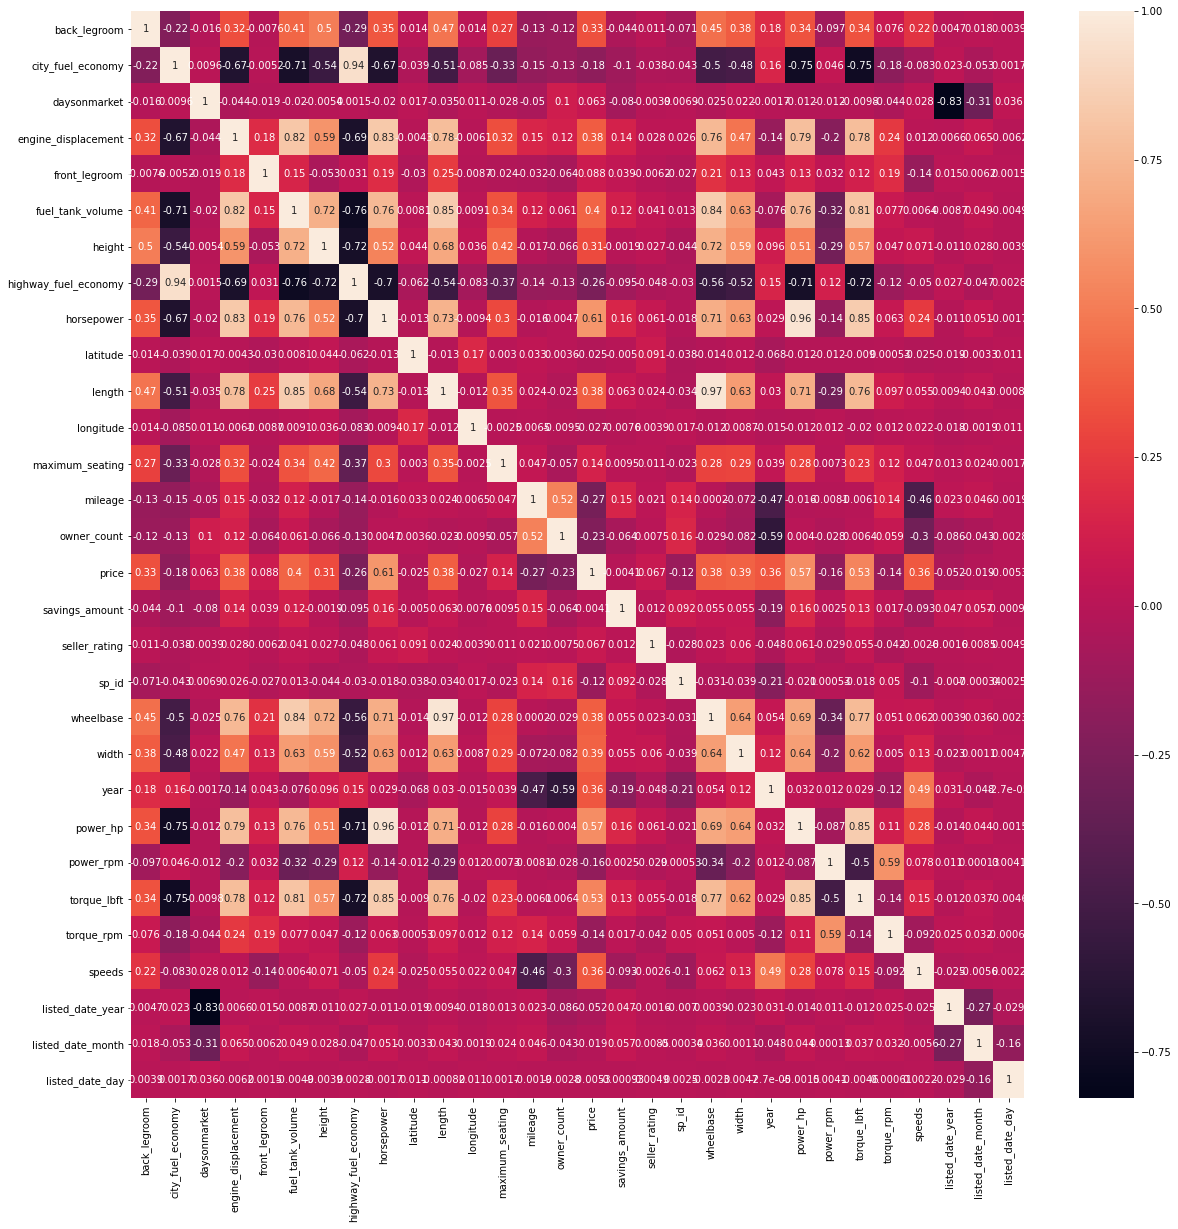

In [17]:
import seaborn as sn
plt.figure(figsize=(20,20))
sn.heatmap(correlation_matr, annot=True)
plt.show()

Сильные корреляции между: 

1) city_fuel_economy & highway_fuel_economy & engine_displacement & fuel_tank_volume & horsepower & length & wheelbase & power_hp & torque_lbft

2) listed_date_year & daysonmarket


In [18]:
df = df.drop(columns = ["city_fuel_economy", "highway_fuel_economy", "engine_displacement", "horsepower", "length", "wheelbase", "power_hp", "torque_lbft", "daysonmarket", "transmission_display"])
df = df.drop(columns = ["frame_damaged", "fleet", "has_accidents", "isCab", "salvage", "theft_title"])

In [19]:
df.shape

(3000000, 42)

In [20]:
from sklearn.tree import DecisionTreeRegressor
y = df["price"]
tmp_df = df.drop(columns=["price"])
tmp_df = tmp_df.select_dtypes(include=['int64', 'float64', 'bool'])
tmp_df.fillna(tmp_df.median(), inplace=True)
reg = DecisionTreeRegressor()
reg = reg.fit(tmp_df, y)
print(reg.feature_importances_)

[0.02614368 0.00142254 0.02112176 0.25320578 0.09328319 0.0065178
 0.01872871 0.01960682 0.01387022 0.22438332 0.00120015 0.00976526
 0.01480597 0.01512255 0.05397147 0.05825658 0.07812885 0.05160686
 0.00773377 0.00524081 0.00925187 0.01663206]


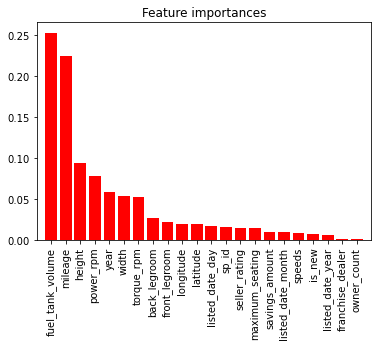

In [21]:
importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(tmp_df.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(tmp_df.shape[1]), tmp_df.columns[indices], rotation=90)

plt.xlim([-1, tmp_df.shape[1]])
plt.show()

In [22]:
tmp_df.describe()

,back_legroom,front_legroom,fuel_tank_volume,height,latitude,longitude,maximum_seating,mileage,owner_count,savings_amount,seller_rating,sp_id,width,year,power_rpm,torque_rpm,speeds,listed_date_year,listed_date_month,listed_date_day
count,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
mean,3.800762e+01,4.219098e+01,1.855995e+01,6.588408e+01,3.698406e+01,-9.064212e+01,5.451861e+00,3.004571e+04,1.263305e+00,5.509753e+02,4.271378e+00,2.335244e+05,7.832694e+01,2.017728e+03,5.803007e+03,3.592674e+03,6.333775e+00,2.019923e+03,7.286192e+00,1.529955e+01
std,2.896782e+00,1.468577e+00,5.312526e+00,7.356446e+00,4.996778e+00,1.390580e+01,1.151084e+00,7.293466e+04,6.997088e-01,1.079447e+03,5.098615e-01,1.323201e+05,7.472133e+00,4.178717e+00,6.812202e+02,1.154377e+03,9.926646e-01,2.947067e-01,2.114120e+00,9.344022e+00
min,3.500000e+00,2.900000e+01,1.900000e+00,4.350000e+01,1.834670e+01,-1.579280e+02,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,4.159300e+04,4.250000e+01,1.915000e+03,5.160000e+02,2.000000e+02,1.000000e+00,2.010000e+03,1.000000e+00,1.000000e+00
25%,3.620000e+01,4.110000e+01,1.480000e+01,5.820000e+01,3.350920e+01,-9.708820e+01,5.000000e+00,6.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,6.337500e+04,7.250000e+01,2.017000e+03,5.600000e+03,3.000000e+03,6.000000e+00,2.020000e+03,7.000000e+00,7.000000e+00
50%,3.820000e+01,4.200000e+01,1.770000e+01,6.610000e+01,3.784710e+01,-8.724950e+01,5.000000e+00,8.267000e+03,1.000000e+00,0.000000e+00,4.341463e+00,2.816270e+05,7.730000e+01,2.020000e+03,6.000000e+03,4.000000e+03,6.000000e+00,2.020000e+03,8.000000e+00,1.500000e+01
75%,3.970000e+01,4.300000e+01,2.100000e+01,7.000000e+01,4.100620e+01,-8.045490e+01,6.000000e+00,4.152900e+04,1.000000e+00,7.850000e+02,4.600000e+00,3.366140e+05,8.250000e+01,2.020000e+03,6.200000e+03,4.400000e+03,6.000000e+00,2.020000e+03,8.000000e+00,2.400000e+01
max,5.980000e+01,6.700000e+01,6.400000e+01,1.176000e+02,6.120310e+01,-6.607850e+01,1.500000e+01,9.999999e+07,1.900000e+01,1.474140e+05,5.000000e+00,4.409510e+05,1.090000e+02,2.021000e+03,9.000000e+03,7.500000e+03,1.000000e+01,2.020000e+03,1.200000e+01,3.100000e+01


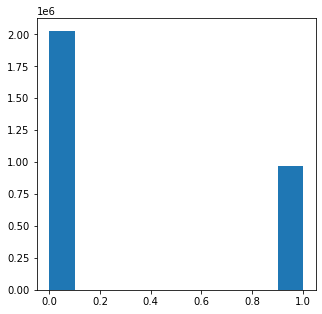

In [23]:
plt.figure(figsize=(5,5))
plt.hist((df["owner_count"]==1).astype(int))
plt.show()

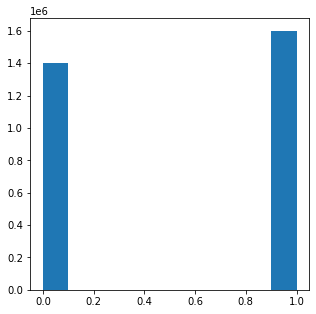

In [24]:
plt.figure(figsize=(5,5))
plt.hist((df["savings_amount"]==0).astype(int))
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


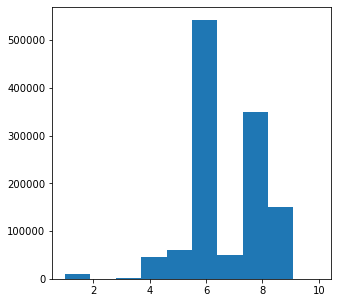

In [25]:
plt.figure(figsize=(5,5))
plt.hist(df["speeds"])
plt.show()

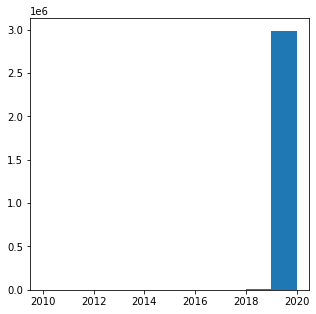

In [26]:
plt.figure(figsize=(5,5))
plt.hist(df["listed_date_year"])
plt.show()

In [27]:
df = df.drop(columns = ["owner_count"])
df["savings_amount"]=df["savings_amount"]==0

In [48]:
# data info
tmp_series = df.groupby(by=["listed_date_year", "listed_date_month"])["price"].agg(["mean", "median"]).sort_values(by=["listed_date_year", "listed_date_month"])

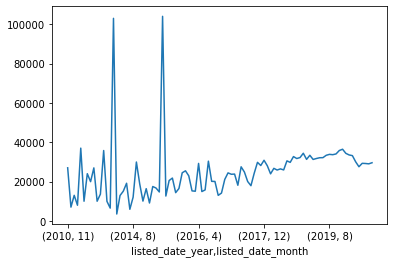

In [49]:
tmp_series["mean"].plot()
plt.show()

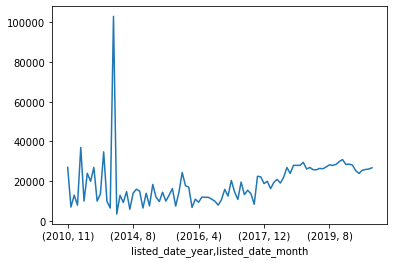

In [50]:
tmp_series["median"].plot()
plt.show()

In [55]:
tmp_series.loc[tmp_series["mean"]==np.max(tmp_series["mean"])]

,,mean,median
listed_date_year,listed_date_month,,
2015,5,104020.071429,14447.5


In [56]:
tmp_series.loc[tmp_series["median"]==np.max(tmp_series["median"])]

,,mean,median
listed_date_year,listed_date_month,,
2014,2,102997.5,102997.5


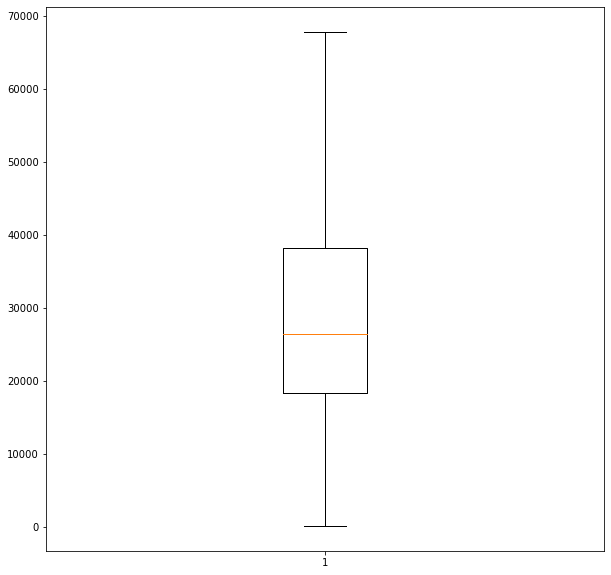

In [60]:
plt.figure(figsize=(10,10))
plt.boxplot(df["price"], showfliers=False)
plt.show()

In [66]:
df["dayofweek"]=df["listed_date"].dt.dayofweek

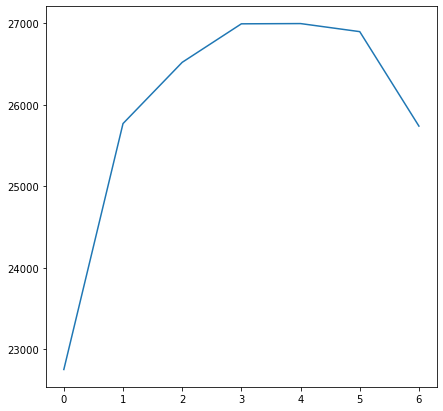

In [68]:
plt.figure(figsize=(7,7))
plt.plot(df.groupby(by="dayofweek")["price"].median())
plt.show()

In [72]:
df= df.drop(columns=["listed_date", "listed_date_day"])

In [73]:
df.to_csv("prepared_used_cars_data.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/output/prepared_used_cars_data.csv'